In [106]:
import os
import glob
import numpy as np
import pandas as pd
import radio
from radio.batchflow import FilesIndex, Dataset, Pipeline
from radio import CTImagesMaskedBatch as CTIMB
from radio_utils import show_slices, get_nodules_pixel_coords, num_of_cancerous_pixels

from config import config
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [32, 32]

# import utils
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [91]:
PATH_TO_FOLDER = config['preprocess_result_path']

path_to_scans_sample = os.path.join(PATH_TO_FOLDER, '*.mhd')
luna_index = FilesIndex(path=path_to_scans_sample, no_ext=True)
lunaset = Dataset(index=luna_index, batch_class=CTIMB)
luna_index.indices

array(['1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860'],
      dtype='<U86')

In [92]:
filelist = [f.split('_label.npy')[0] for f in os.listdir(PATH_TO_FOLDER) if f.endswith('_label.npy') ]

columns_df = ['coordZ', 'coordY', 'coordX', 'diameter_mm', 'seriesuid']
columns_temp = ['coordZ', 'coordY', 'coordX', 'diameter_mm']
nodules_df = pd.DataFrame([], columns=columns_new)

for file in filelist:
    annot = np.load(os.path.join(PATH_TO_FOLDER, file + '_label.npy'))
    temp = pd.DataFrame(annot, columns=columns_temp)
    temp['seriesuid'] = file
    nodules_df = pd.concat([nodules_df, temp])
print(len(nodules_df))

2


In [93]:
preprocessing = (Pipeline()
                .load(fmt='raw')
                .fetch_nodules_info(nodules_df)
                .create_mask())

In [95]:
batch = (lunaset >> preprocessing).next_batch(1, shuffle=False)

In [96]:
get_nodules_pixel_coords(batch)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,130,100,23,6
1,0,201,64,255,4


In [114]:
crops_sampling_pipeline = preprocessing.sample_nodules(batch_size=4, nodule_size=(64, 64, 64))

In [115]:
np.random.seed(42)
batch_crops = (lunaset >> crops_sampling_pipeline).next_batch(2, shuffle=False)

In [116]:
get_nodules_pixel_coords(batch_crops)

,numeric_ix,coordZ,coordY,coordX,diameter_pixels
0,0,32,32,32,4
1,1,32,32,23,6


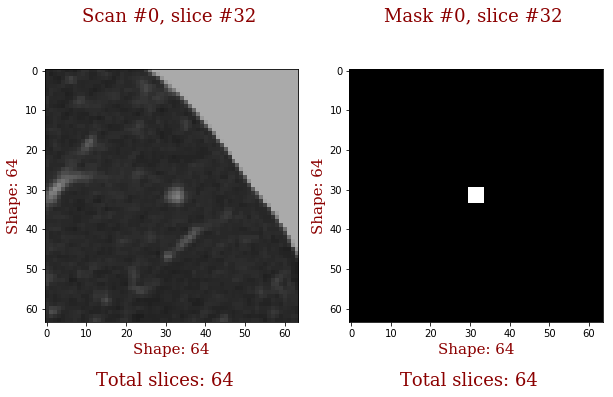

In [125]:
show_slices(batch_crops, 0, 32, components=['images', 'masks'], clims=[(0, 255), (0, 1)], grid=False)

In [122]:
num_of_cancerous_pixels(batch_crops)

,Scan 0,Scan 1,Scan 2,Scan 3
Number of cancerous pixels:,64,216,0,0
